## Data Import and Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
midwest_abbrs = ["IL", "IN", "IA", "KS", "MI", "MN", "MO", "NE", "ND", "OH", "SD", "WI"]
midwest_states = ["Illinois", "Indiana", "Iowa", "Kansas", "Michigan", "Minnesota", "Missouri", 
                  "Nebraska", "North Dakota", "Ohio", "South Dakota", "Wisconsin"]

### Covid 19 Case Data from the New York Times
Generally pretty clean already, but let's just take a look and organize a bit

In [3]:
NYT_df = pd.read_csv("../Raw Data/NYT-us-counties.csv", parse_dates=["date"], dtype={'fips': str, 'cases': int})
NYT_df.shape

(1212589, 6)

In [4]:
NYT_df.describe(datetime_is_numeric=True)

,date,cases,deaths
count,1212589,1212589.00,1185950.00
mean,2020-10-05 14:08:06.898034688,3700.88,79.99
min,2020-01-21 00:00:00,0.00,0.00
25%,2020-07-05 00:00:00,74.00,1.00
50%,2020-10-07 00:00:00,500.00,9.00
75%,2021-01-08 00:00:00,1993.00,40.00
max,2021-04-11 00:00:00,1226456.00,31792.00
std,NaN,19522.54,545.56


Looks like cases data is pretty complete, but there are some NAs for deaths.  Let's investigate...

In [5]:
NYT_df[NYT_df["deaths"].isnull()].head()

,date,county,state,fips,cases,deaths
117486,2020-05-05,Adjuntas,Puerto Rico,72001,3,NaN
117487,2020-05-05,Aguada,Puerto Rico,72003,7,NaN
117488,2020-05-05,Aguadilla,Puerto Rico,72005,11,NaN
117489,2020-05-05,Aguas Buenas,Puerto Rico,72007,22,NaN
117490,2020-05-05,Aibonito,Puerto Rico,72009,13,NaN


According to the documentation, Puerto Rico didn't report deaths at the municipal level, which explains the NA.  That's okay because we'll be narrowing down to the Midwest anyways

Let's look at what other territories were included

In [6]:
np.unique(NYT_df["state"]) # Looks like we have Guam, Northern Mariana Islands, Puerto Rico

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Northern Mariana Islands',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

Cases and deaths data is cumulative, so let's add columns for new cases and death

In [7]:
NYT_df.sort_values(by=["state", "fips", "county", "date"], inplace=True)

NYT_df['new_cases'] = NYT_df.groupby(["state", "fips", "county"])['cases'].diff()
NYT_df['new_deaths'] = NYT_df.groupby(["state", "fips", "county"])['deaths'].diff()

# re-label old columns
NYT_df = NYT_df.rename(columns={"cases": "cumulative_cases", "deaths": "cumulative_deaths"})

NYT_df.head()

,date,county,state,fips,cumulative_cases,cumulative_deaths,new_cases,new_deaths
9480,2020-03-24,Autauga,Alabama,01001,1,0.00,NaN,NaN
10835,2020-03-25,Autauga,Alabama,01001,4,0.00,3.00,0.00
12367,2020-03-26,Autauga,Alabama,01001,6,0.00,2.00,0.00
14025,2020-03-27,Autauga,Alabama,01001,6,0.00,0.00,0.00
15803,2020-03-28,Autauga,Alabama,01001,6,0.00,0.00,0.00


Now lets filter just to midwest states:

In [8]:
NYT_midwest = NYT_df[NYT_df["state"].isin(midwest_states)]

NYT_midwest.shape

(392423, 8)

Let's visualize data by state and check for outliers

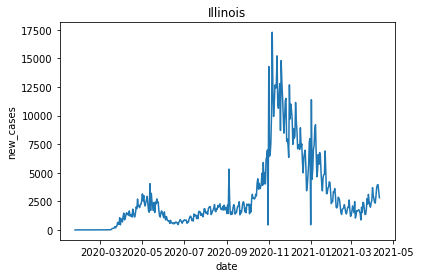

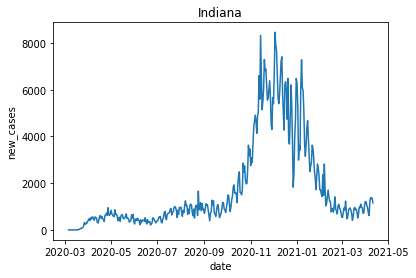

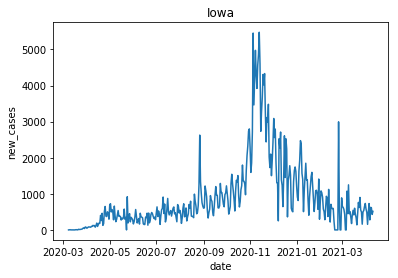

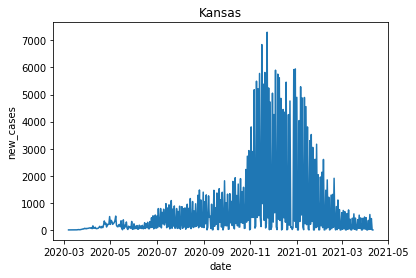

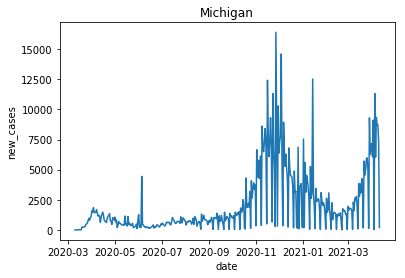

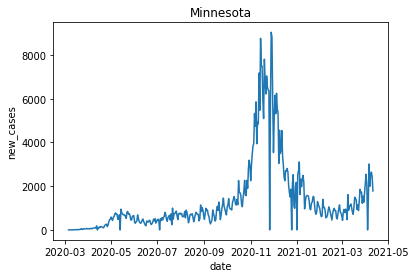

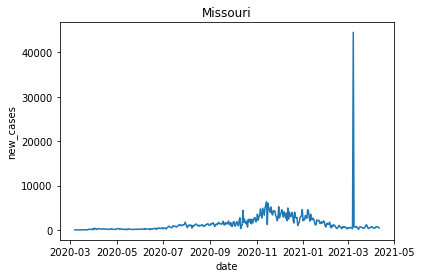

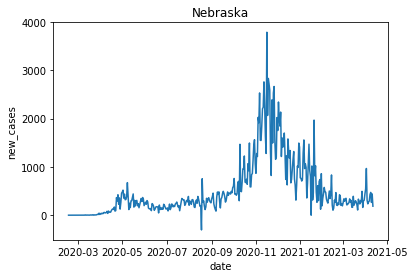

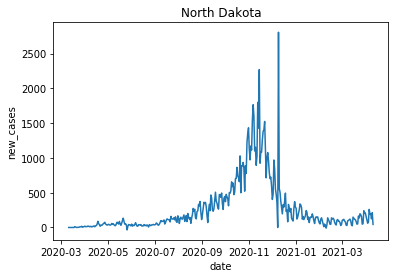

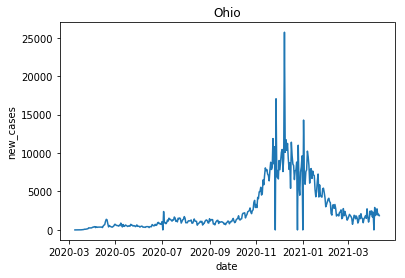

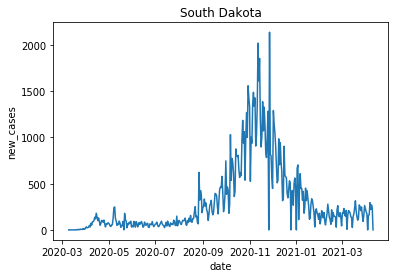

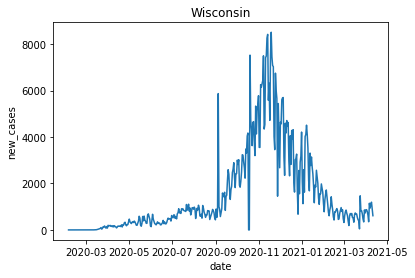

In [9]:
NYT_midwest_states = NYT_midwest.groupby(["state", "date"]).agg("sum")

NYT_midwest_states.reset_index(inplace=True)
NYT_midwest_states.set_index("date", inplace=True)

for state in midwest_states:
    plt.figure()
    plt_data = NYT_midwest_states[NYT_midwest_states["state"]==state]
    sns.lineplot(data=plt_data, x=plt_data.index, y="new_cases")
    plt.title(state)

Now let's check missingness by county

In [10]:
print("# counties in the dataset for the midwest: %d" % len(NYT_midwest[["county", "state"]].drop_duplicates()))
print("# days covered in this data: %d" % len(NYT_midwest["date"].unique()))

# counties in the dataset for the midwest: 1069
# days covered in this data: 444


In [11]:
NYT_midwest.describe()

,cumulative_cases,cumulative_deaths,new_cases,new_deaths
count,392423.00,392423.00,388403.00,388403.00
mean,2488.29,46.95,17.19,0.29
std,11277.76,255.18,80.62,2.16
min,0.00,0.00,-392.00,-155.00
25%,50.00,0.00,0.00,0.00
50%,372.00,6.00,2.00,0.00
75%,1594.00,29.00,10.00,0.00
max,512773.00,10310.00,6697.00,277.00


In [12]:
pd.set_option('display.max_rows', None)
NYT_midwest.groupby(["state", "county"]).count()

date  fips  cumulative_cases  \
state        county                                            
Illinois     Adams               388   388               388   
             Alexander           361   361               361   
             Bond                379   379               379   
             Boone               372   372               372   
             Brown               346   346               346   
             Bureau              381   381               381   
             Calhoun             372   372               372   
             Carroll             380   380               380   
             Cass                357   357               357   
             Champaign           386   386               386   
             Christian           388   388               388   
             Clark               378   378               378   
             Clay                363   363               363   
             Clinton             393   393               393   
             Coles               370   370               370   
             Cook                444   444               444   
             Crawford            378   378               378   
             Cumberland          394   394               394   
             De Witt             374   374               374   
             DeKalb              387   387               387   
             Douglas             383   383               383   
             DuPage              394   394               394   
             Edgar               318   318               318   
             Edwards             334   334               334   
             Effingham           374   374               374   
             Fayette             380   380               380   
             Ford                377   377               377   
             Franklin            382   382               382   
             Fulton              367   367               367   
             Gallatin            372   372               372   
             Greene              367   367               367   
             Grundy              384   384               384   
             Hamilton            359   359               359   
             Hancock             369   369               369   
             Hardin              356   356               356   
             Henderson           360   360               360   
             Henry               381   381               381   
             Iroquois            381   381               381   
             Jackson             390   390               390   
             Jasper              373   373               373   
             Jefferson           371   371               371   
             Jersey              374   374               374   
             Jo Daviess          386   386               386   
             Johnson             364   364               364   
             Kane                398   398               398   
             Kankakee            390   390               390   
             Kendall             390   390               390   
             Knox                379   379               379   
             LaSalle             390   390               390   
             Lake                397   397               397   
             Lawrence            370   370               370   
             Lee                 373   373               373   
             Livingston          386   386               386   
             Logan               375   375               375   
             Macon               380   380               380   
             Macoupin            375   375               375   
             Madison             390   390               390   
             Marion              378   378               378   
             Marshall            383   383               383   
             Mason               373   373               373   
             Massac              376   376               376   


I'm assuming each state/county started reported covid data at different dates, which is fine since it seems like every county reports data for at least a year

### Data Summary and To Dos

#### Summary
- Data seems pretty complete and everything looks good for using this data

#### To Do:
- Based on the graphs, there seems like there's a tiny bit of weirdness in some counts, so we should just spot check some of those
- Think about how we want to lag this data when we use it as a predictor

## Variant Data from Helix

From Helix documentation: "Drawing from samples collected during routine lower-nasal swab COVID-19 testing, typically at Helix-supported testing sites across the country, a subset of positive samples are chosen for follow-on sequencing based on demographics, sample quality, test characteristics, or simply random selection."

Because Helix only sequences a sample of their positive cases, I think we should only use Helix for the "Number of positive test results with S gene target failure" (variable name "all_SGTF") and not the variables involving sequencing.  S gene target failure is theorized to be a marker for B117 but it's definitely not exact, but I think as good as we can do with this data. (https://jamanetwork.com/journals/jama/fullarticle/2778599)

This data is also on the state level rather than the county level.

In [13]:
helix = pd.read_csv("../Raw Data/helix.csv", parse_dates=["collection_date"])
helix.head()

,state,collection_date,positive,all_SGTF,sequenced_SGTF,B117
0,PR,2020-09-05,3,0,0,0
1,VA,2020-09-05,3,0,0,0
2,FL,2020-09-06,8,0,0,0
3,CA,2020-09-07,8,0,0,0
4,AL,2020-09-08,3,0,0,0


In [14]:
helix.shape

(3927, 6)

In [15]:
helix_midwest = helix[helix["state"].isin(midwest_abbrs)]
helix_midwest.shape

(978, 6)

In [16]:
helix_midwest.head()

,state,collection_date,positive,all_SGTF,sequenced_SGTF,B117
7,IL,2020-09-08,4,0,0,0
9,MO,2020-09-08,3,0,0,0
10,OH,2020-09-08,3,0,0,0
26,MN,2020-09-12,4,0,0,0
38,IL,2020-09-15,6,0,0,0


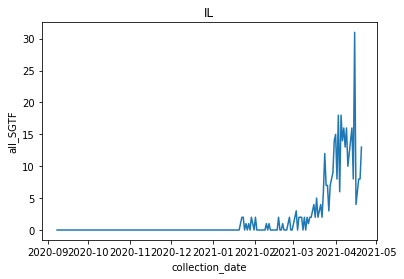

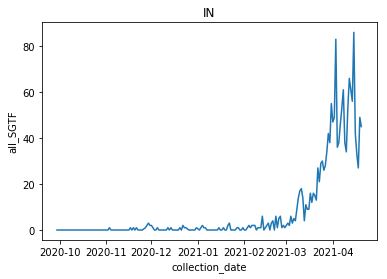

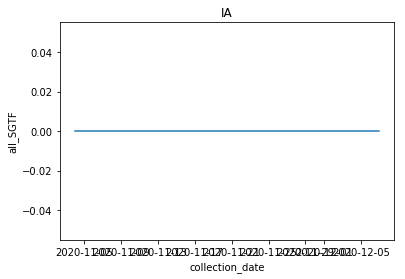

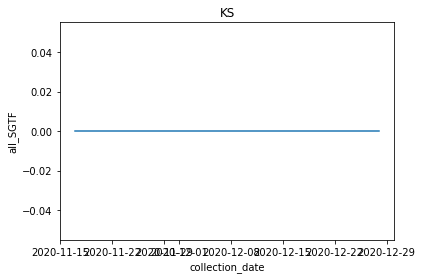

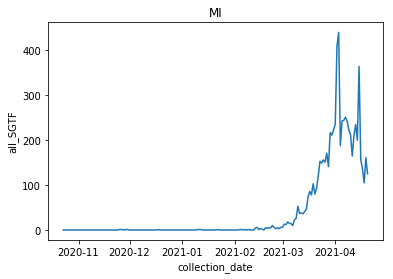

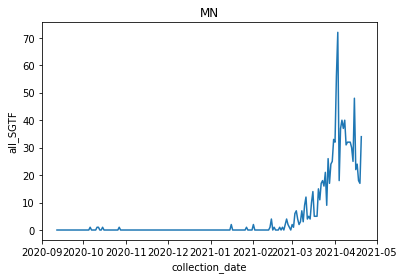

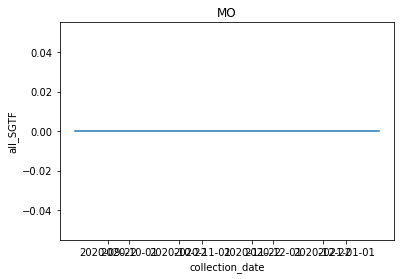

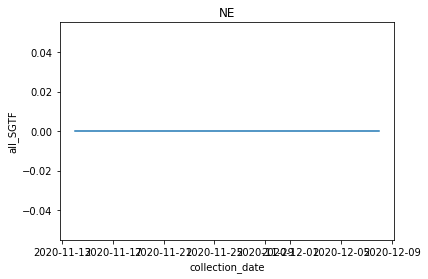

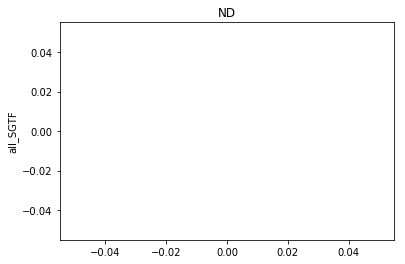

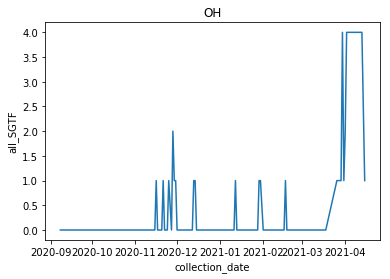

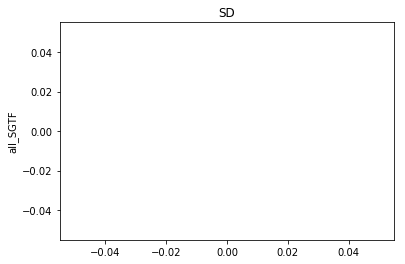

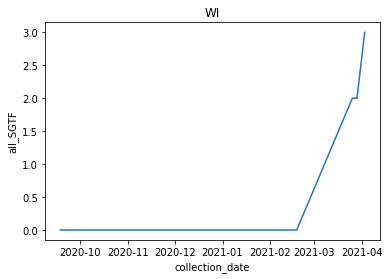

In [17]:
helix_midwest.set_index("collection_date", inplace=True)
for state in midwest_abbrs:
    plt.figure()
    plt_data = helix_midwest[helix_midwest["state"]==state]
    sns.lineplot(data=plt_data, x=plt_data.index, y="all_SGTF")
    plt.title(state)

In [18]:
# check whether SD and ND are just absent from the data
np.unique(helix_midwest.state)

array(['IA', 'IL', 'IN', 'KS', 'MI', 'MN', 'MO', 'NE', 'OH', 'WI'],
      dtype=object)

So it appears that North Dakota and South Dakota are just absent from this Helix data.  This would be an issue if we were to use Helix as the only form of variant data.

Looks like the rate of variants is just very varied across states generally

In [19]:
# let's make cumulative columns
cumulative_all_SGTF = helix_midwest[["state", "all_SGTF", "B117"]].groupby(['state','collection_date']).sum() \
                                                          .groupby(level=0).cumsum().reset_index()
cumulative_all_SGTF.rename(columns={"all_SGTF": "cumulative_SGTF", "B117" : "cumulative_B117"}, inplace=True)

helix_midwest = helix_midwest.merge(cumulative_all_SGTF, on=["state", "collection_date"])

helix_midwest.head()

,state,collection_date,positive,all_SGTF,sequenced_SGTF,B117,cumulative_SGTF,cumulative_B117
0,IL,2020-09-08,4,0,0,0,0,0
1,MO,2020-09-08,3,0,0,0,0,0
2,OH,2020-09-08,3,0,0,0,0,0
3,MN,2020-09-12,4,0,0,0,0,0
4,IL,2020-09-15,6,0,0,0,0,0


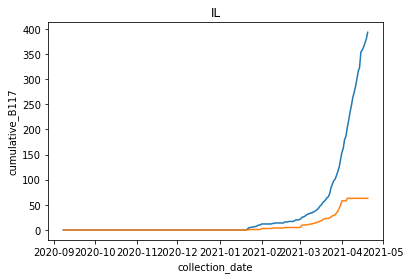

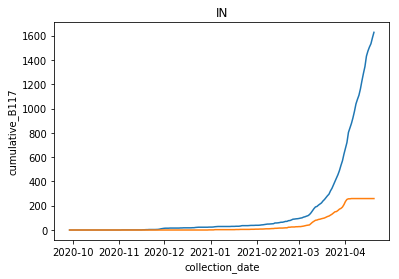

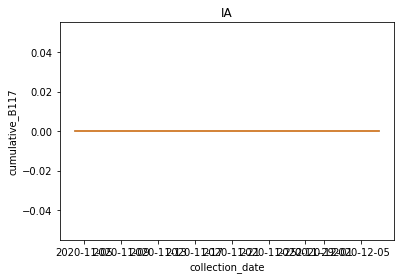

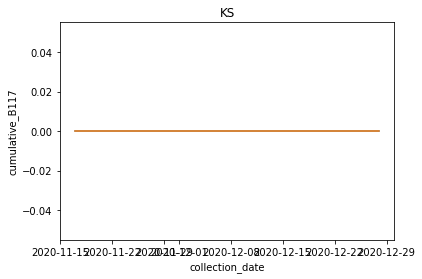

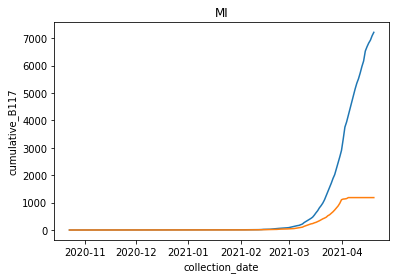

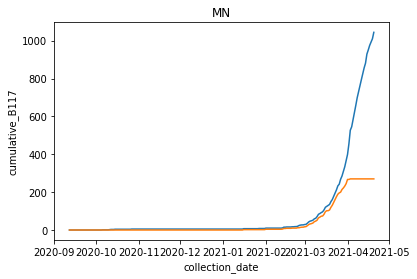

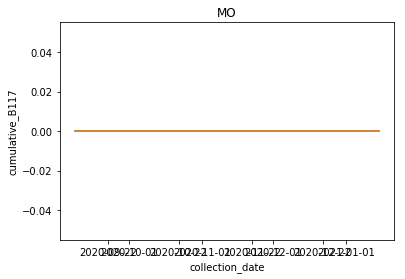

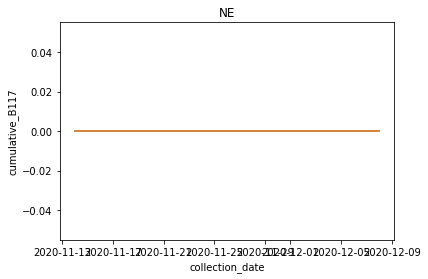

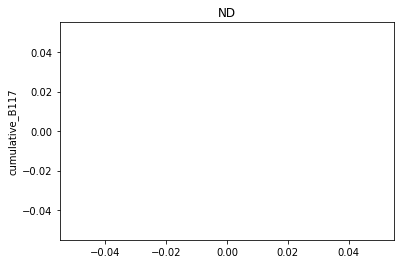

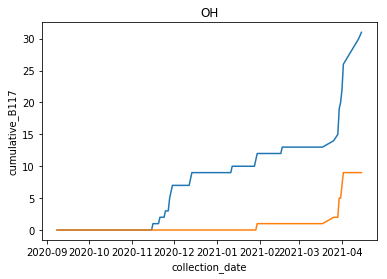

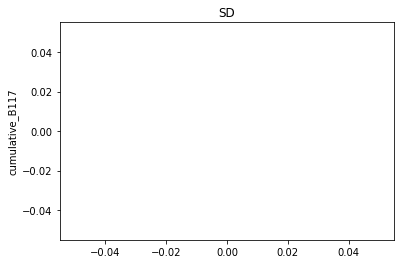

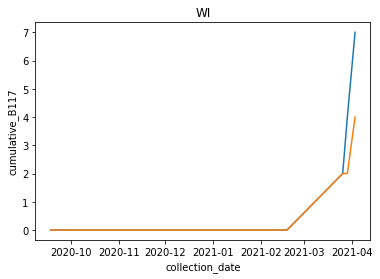

In [20]:
helix_midwest.set_index("collection_date", inplace=True)
for state in midwest_abbrs:
    plt.figure()
    plt_data = helix_midwest[helix_midwest["state"]==state]
    sns.lineplot(data=plt_data, x=plt_data.index, y="cumulative_SGTF")
    sns.lineplot(data=plt_data, x=plt_data.index, y="cumulative_B117")
    plt.title(state)

I don't think the Wisconsin data is complete because this data reports that they only have a handful of variant cases but the Wisconsin DHS definitely reports a lot more (https://www.dhs.wisconsin.gov/covid-19/variants.htm).

### Data Summary and To Dos

#### Summary
- Data is missing for ND and SD entirely
- Data looks very incomplete for Wisconsin
- Generally data seems a pretty unreliable upon matching against CDC current cumulative numbers: https://www.cdc.gov/coronavirus/2019-ncov/transmission/variant-cases.html Doesn't seem like it's a consistant subsample across states so not sure how usable this is...

#### To Do:
- Maybe check the CDC page again for their data?  Or hopefully the GISAid data will be more helpful

## CMS Data on Public Mask Mandates

Source: https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i
"State and territorial executive orders, administrative orders, resolutions, and proclamations are collected from government websites" 

In [21]:
Masks_df = pd.read_csv("../Raw Data/CMS-Public_Mask_Mandates.csv", parse_dates=["date"])
Masks_df.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (8,9,10,11,13,14,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Current_order_status,Jurisdiction_Type,Issuing_Jurisdiction,Face_Masks_Required_in_Public,Effective_date,Expiration_date,Effective_NA_Reason,Expiration_NA_Reason,Date_Signed,origin_dataset,Source_of_Action,URL,Citation
0,AL,Autauga County,1,1,2020-04-10,2,No Public Mask Mandate,State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AL,Autauga County,1,1,2020-04-11,2,No Public Mask Mandate,State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AL,Autauga County,1,1,2020-04-12,2,No Public Mask Mandate,State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AL,Autauga County,1,1,2020-04-13,2,No Public Mask Mandate,State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AL,Autauga County,1,1,2020-04-14,2,No Public Mask Mandate,State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lots of interesting variables.  Let's explore...

In [22]:
Midwest_Masks_df = Masks_df[Masks_df["State_Tribe_Territory"].isin(midwest_abbrs)]
Midwest_Masks_df.shape

(366085, 19)

In [23]:
# Let's look at the types of mask orders
np.unique(Midwest_Masks_df.Current_order_status) # okay so basically just a binary

array(['No Public Mask Mandate', 'Public Mask Mandate'], dtype=object)

In [24]:
# Let's look at the different jurisdiction types
np.unique(Midwest_Masks_df.Jurisdiction_Type) # hmmmm just state

array(['State'], dtype=object)

In [25]:
# Let's look at the different jurisdiction types for all states
np.unique(Masks_df.Jurisdiction_Type) # okay so basically just literally state or territory level

array(['District (state)', 'State', 'Territory'], dtype=object)

In [26]:
Masks_df[Masks_df["Jurisdiction_Type"]=="District (state)"].head(3)

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Current_order_status,Jurisdiction_Type,Issuing_Jurisdiction,Face_Masks_Required_in_Public,Effective_date,Expiration_date,Effective_NA_Reason,Expiration_NA_Reason,Date_Signed,origin_dataset,Source_of_Action,URL,Citation
84890,DC,District of Columbia,11,1,2020-05-16,1,Public Mask Mandate,District (state),DC,Yes,2020-05-16,2020-06-08,NaN,NaN,2020-05-13,state.terr,Official,https://www.dcregs.dc.gov/Common/NoticeDetail....,"D.C. Mayor's Order No. 2020-066 (May 13, 2020)"
84891,DC,District of Columbia,11,1,2020-05-17,1,Public Mask Mandate,District (state),DC,Yes,2020-05-16,2020-06-08,NaN,NaN,2020-05-13,state.terr,Official,https://www.dcregs.dc.gov/Common/NoticeDetail....,"D.C. Mayor's Order No. 2020-066 (May 13, 2020)"
84892,DC,District of Columbia,11,1,2020-05-18,1,Public Mask Mandate,District (state),DC,Yes,2020-05-16,2020-06-08,NaN,NaN,2020-05-13,state.terr,Official,https://www.dcregs.dc.gov/Common/NoticeDetail....,"D.C. Mayor's Order No. 2020-066 (May 13, 2020)"


In [27]:
Masks_df[Masks_df["Jurisdiction_Type"]=="Territory"].head(3)

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Current_order_status,Jurisdiction_Type,Issuing_Jurisdiction,Face_Masks_Required_in_Public,Effective_date,Expiration_date,Effective_NA_Reason,Expiration_NA_Reason,Date_Signed,origin_dataset,Source_of_Action,URL,Citation
835772,AS,Eastern District,60,10,2020-04-10,2,No Public Mask Mandate,Territory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835773,AS,Eastern District,60,10,2020-04-11,2,No Public Mask Mandate,Territory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835774,AS,Eastern District,60,10,2020-04-12,2,No Public Mask Mandate,Territory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Soooo basically this data is on the state level.  Which is still helpful.  Let's just check dates/trends

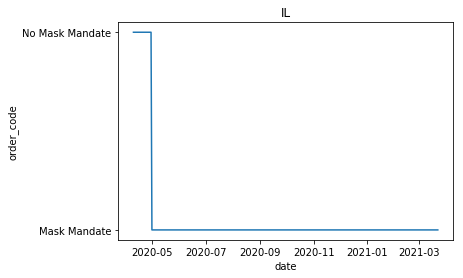

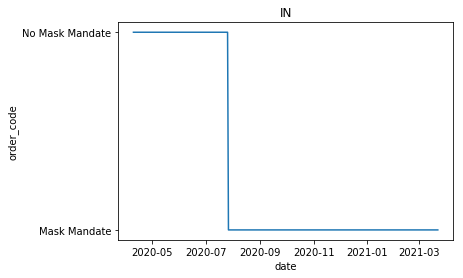

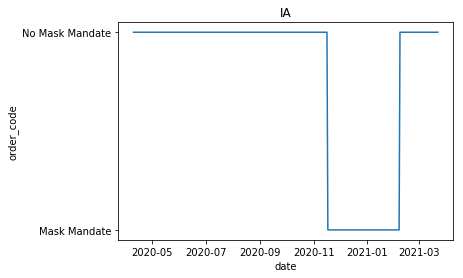

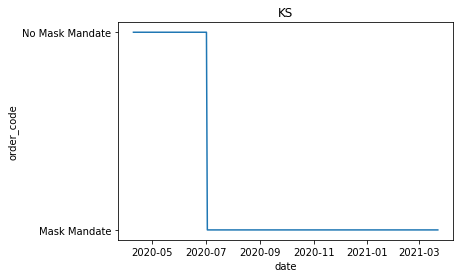

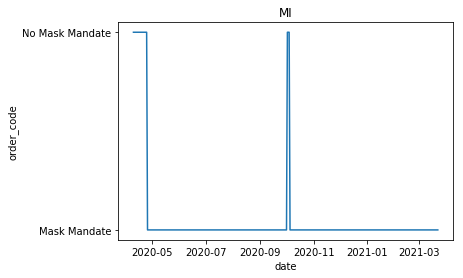

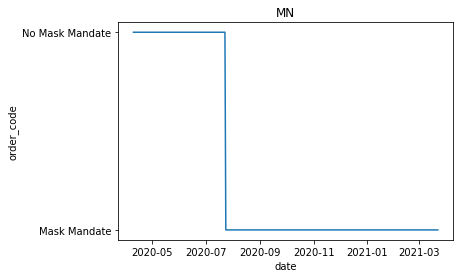

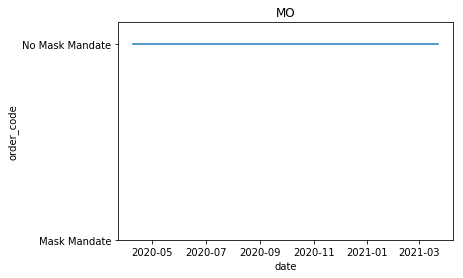

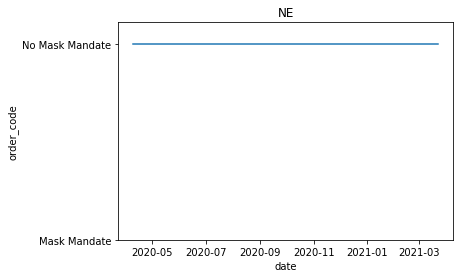

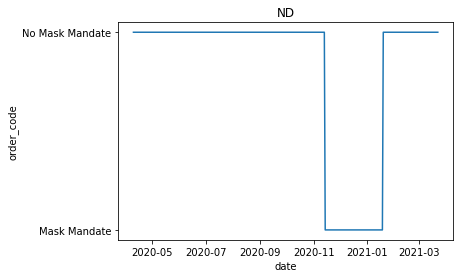

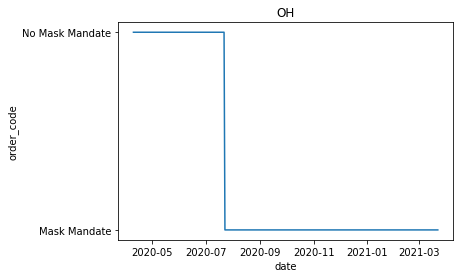

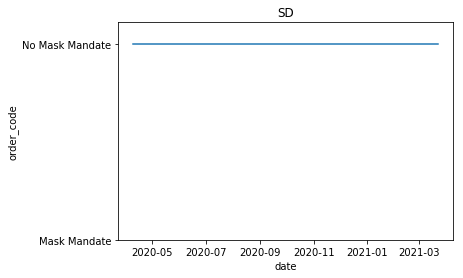

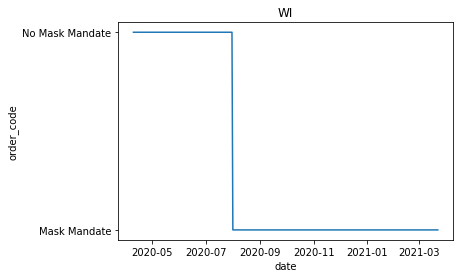

In [28]:
Midwest_Masks_df_states = Midwest_Masks_df[["date", "State_Tribe_Territory", "order_code"]].groupby(["date", "State_Tribe_Territory"]).max()
Midwest_Masks_df_states.reset_index(inplace=True)

Midwest_Masks_df_states.set_index("date", inplace=True)
for state in midwest_abbrs:
    plt.figure()
    plt_data = Midwest_Masks_df_states[Midwest_Masks_df_states["State_Tribe_Territory"]==state]
    sns.lineplot(data=plt_data, x=plt_data.index, y="order_code")
    plt.title(state)
    plt.yticks([1,2], labels=["Mask Mandate", "No Mask Mandate"])

In [32]:
# Let's investigate the random blip in Michigan
pd.set_option('display.max_rows', None)
Midwest_Masks_df[(Midwest_Masks_df["State_Tribe_Territory"]=="MI") & \
                 (Midwest_Masks_df["County_Name"]=="Alcona County") & \
                 (Midwest_Masks_df["date"] < '2020-10-10') & \
                 (Midwest_Masks_df["date"] > '2020-9-30')]
# I think this checks out against articles about the state mandate and then the Health Order

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Current_order_status,Jurisdiction_Type,Issuing_Jurisdiction,Face_Masks_Required_in_Public,Effective_date,Expiration_date,Effective_NA_Reason,Expiration_NA_Reason,Date_Signed,origin_dataset,Source_of_Action,URL,Citation
327620,MI,Alcona County,26,1,2020-10-01,1,Public Mask Mandate,State,MI,Yes,2020-09-25,NaN,NaN,Not listed,2020-09-25,state.terr,Official,https://legislature.mi.gov/documents/2019-2020...,"Mich. Exec. Order No. 2020-184 (Sept. 25, 2020)"
327621,MI,Alcona County,26,1,2020-10-02,2,No Public Mask Mandate,State,MI,No,2020-10-02,NaN,NaN,NaN,2020-10-02,state.terr,Official,https://courts.michigan.gov/Courts/MichiganSup...,In re Certified Questions from the United Stat...
327622,MI,Alcona County,26,1,2020-10-03,2,No Public Mask Mandate,State,MI,No,2020-10-02,NaN,NaN,NaN,2020-10-02,state.terr,Official,https://courts.michigan.gov/Courts/MichiganSup...,In re Certified Questions from the United Stat...
327623,MI,Alcona County,26,1,2020-10-04,2,No Public Mask Mandate,State,MI,No,2020-10-02,NaN,NaN,NaN,2020-10-02,state.terr,Official,https://courts.michigan.gov/Courts/MichiganSup...,In re Certified Questions from the United Stat...
327624,MI,Alcona County,26,1,2020-10-05,1,Public Mask Mandate,State,MI,Yes,2020-10-05,2020-10-30,NaN,NaN,2020-10-05,state.terr,Official,https://www.michigan.gov/documents/coronavirus...,"Mich. Health Order (Oct. 5, 2020)"
327625,MI,Alcona County,26,1,2020-10-06,1,Public Mask Mandate,State,MI,Yes,2020-10-05,2020-10-30,NaN,NaN,2020-10-05,state.terr,Official,https://www.michigan.gov/documents/coronavirus...,"Mich. Health Order (Oct. 5, 2020)"
327626,MI,Alcona County,26,1,2020-10-07,1,Public Mask Mandate,State,MI,Yes,2020-10-05,2020-10-30,NaN,NaN,2020-10-05,state.terr,Official,https://www.michigan.gov/documents/coronavirus...,"Mich. Health Order (Oct. 5, 2020)"
327627,MI,Alcona County,26,1,2020-10-08,1,Public Mask Mandate,State,MI,Yes,2020-10-05,2020-10-30,NaN,NaN,2020-10-05,state.terr,Official,https://www.michigan.gov/documents/coronavirus...,"Mich. Health Order (Oct. 5, 2020)"
327628,MI,Alcona County,26,1,2020-10-09,1,Public Mask Mandate,State,MI,Yes,2020-10-09,2020-10-30,NaN,NaN,2020-10-09,state.terr,Official,https://www.michigan.gov/documents/coronavirus...,"Mich. Health Order (Oct. 9, 2020)"


### Data Summary and To Dos

#### Summary
- Data is at the state level rather than the county level, which is less granular than expected, but will still be helpful
- Spotchecked for accuracy and data seems pretty consistent

#### To Do:
- Think about whether we want to use the lagged version of this for features

## CMS Data on Hospital Utilization

Source: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u

Data reported on a weekly basis

I think our main variables of interest will be:
- "total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum": Sum of reports of patients currently hospitalized in an adult inpatient bed who have laboratory-confirmed or suspected COVID19. Including those in observation beds reported during the 7-day period.


- "total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum": Sum of reports of patients currently hospitalized in a pediatric inpatient bed, including NICU, PICU, newborn, and nursery, who have laboratory-confirmed COVID-19. Including those in observation beds. Including patients who have both laboratory-confirmed COVID-19 and laboratory confirmed influenza in this field reported in the 7-day period.

In [33]:
Hosp_Util_df_raw = pd.read_csv("../Raw Data/CMS-Hospital_Utilization.csv", parse_dates=["collection_week"])
Hosp_Util_df_raw.head()

,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,...,previous_day_admission_adult_covid_suspected_40-49_7_day_sum,previous_day_admission_adult_covid_suspected_50-59_7_day_sum,previous_day_admission_adult_covid_suspected_60-69_7_day_sum,previous_day_admission_adult_covid_suspected_70-79_7_day_sum,previous_day_admission_adult_covid_suspected_80+_7_day_sum,previous_day_admission_adult_covid_suspected_unknown_7_day_sum,previous_day_admission_pediatric_covid_suspected_7_day_sum,previous_day_total_ED_visits_7_day_sum,previous_day_admission_influenza_confirmed_7_day_sum,geocoded_hospital_address
0,36db6bad3679dfdcccc301fc608438109ad907943c702f...,2021-04-09,PR,NaN,CDT Susana Centeno,NaN,NaN,765.00,Short Term,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72.00,0.00,POINT (-66.414655 18.215692)
1,3b081d5ef1c552538e4af4aa593a857bb922a4f364a412...,2021-04-09,LA,NaN,Surgery Center of Zachary,NaN,NaN,70791.00,Short Term,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,POINT (-91.145057 30.655648)
2,df2363988746840134806aa7b2accf9c89259601776986...,2021-04-09,PR,NaN,Hospital San Antonio,"#18 Norte, Calle Dr",Mayagüez,680.00,Short Term,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,-999999.00,202.00,0.00,NaN
3,976b4ce7c95e1cd394112ce7762ed040f18a141e56a52e...,2021-04-09,PR,NaN,Hospital Industrial C.F.S.E,Paseo Dr. Jose Celso Barbosa,San Juan,935.00,Short Term,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN
4,f70d7abf93c78280583ac18e896e6737cca8212b017513...,2021-04-09,NV,NaN,Elite Medical Center,150 E Harmon Ave,Las Vegas,89109.00,Short Term,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00,0.00,POINT (-115.165444 36.10808)


In [34]:
# filter down to relevant variables
Hospit_Util_df = Hosp_Util_df_raw[["collection_week",
                                  "state",
                                  "ccn",
                                  "hospital_name",
                                  "city",
                                  "fips_code",
                                  "total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum",
                                  "total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum"]]

Hospit_Util_df.columns=["collection_week", "state", "ccn", "hospital_name", "city", "fips_code", 
                          "total_adult_hospitalizations", "total_pediatric_hospitalizations"]

In [35]:
Hospit_Util_df.describe(datetime_is_numeric=True)

,collection_week,fips_code,total_adult_hospitalizations,total_pediatric_hospitalizations
count,184384,183988.00,182031.00,181870.00
mean,2020-12-04 14:46:33.561263360,29446.50,-69184.43,-65275.56
min,2020-07-31 00:00:00,1001.00,-999999.00,-999999.00
25%,2020-10-02 00:00:00,17051.00,0.00,0.00
50%,2020-12-04 00:00:00,29011.00,22.00,0.00
75%,2021-02-05 00:00:00,42091.00,107.00,0.00
max,2021-04-09 00:00:00,78020.00,6503.00,33045.00
std,NaN,16199.38,253955.08,247015.60


Some negative numbers.  From documentation:

_Suppression is applied to the file for sums and averages less than four (4). In these cases, the field will be replaced with “-999,999”._

Let's just code that as 3 for now

In [36]:
Hospit_Util_df = Hospit_Util_df.replace(-999999., 3)

In [37]:
# looks better
Hospit_Util_df.describe(datetime_is_numeric=True)

,collection_week,fips_code,total_adult_hospitalizations,total_pediatric_hospitalizations
count,184384,183988.00,182031.00,181870.00
mean,2020-12-04 14:46:33.561263360,29446.50,95.12,1.97
min,2020-07-31 00:00:00,1001.00,0.00,-40.00
25%,2020-10-02 00:00:00,17051.00,3.00,0.00
50%,2020-12-04 00:00:00,29011.00,22.00,0.00
75%,2021-02-05 00:00:00,42091.00,107.00,0.00
max,2021-04-09 00:00:00,78020.00,6503.00,33045.00
std,NaN,16199.38,186.44,78.37


Data only available form 7-31-2020 onwards

In [38]:
# filter down to Midwest hospitals
hosp_midwest = Hospit_Util_df[Hospit_Util_df["state"].isin(midwest_abbrs)]
hosp_midwest.shape

(53271, 8)

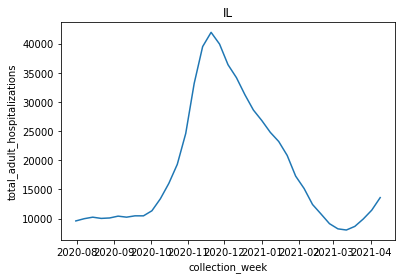

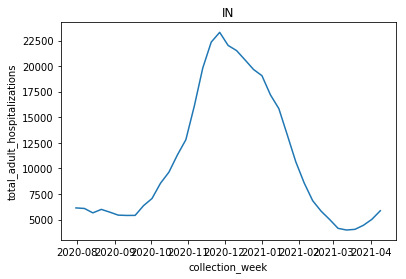

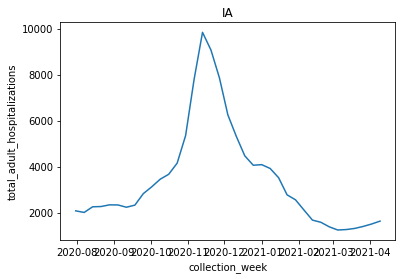

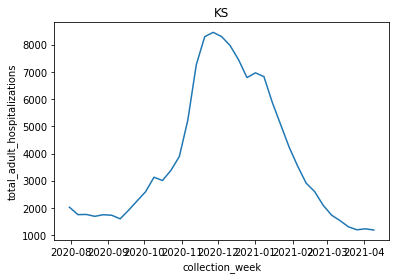

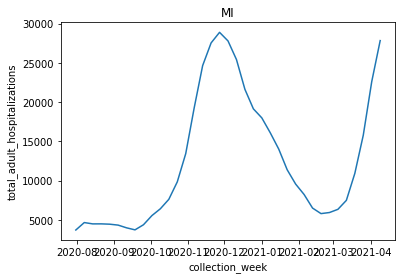

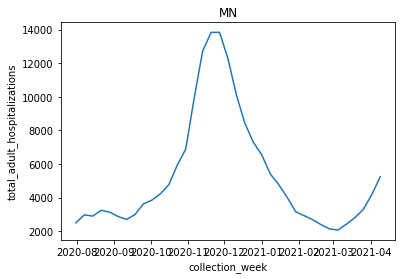

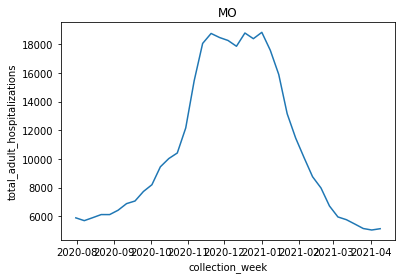

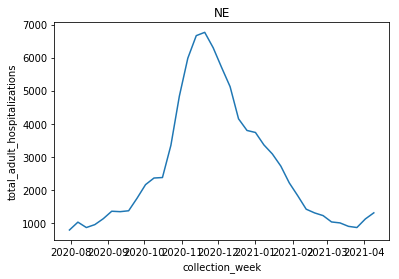

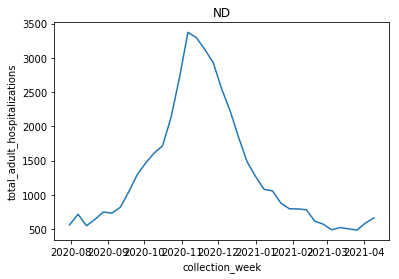

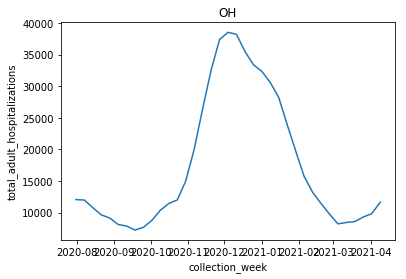

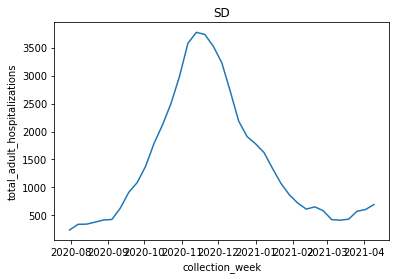

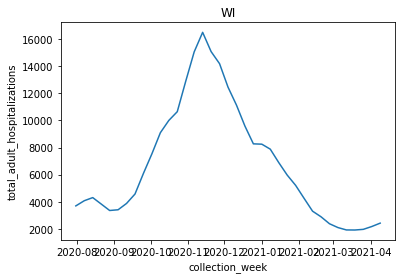

In [39]:
# aggregate and visualize at the state level
hosp_midwest_state_level = hosp_midwest.groupby(["collection_week", "state"]).agg("sum")
hosp_midwest_state_level.reset_index(inplace=True)

hosp_midwest_state_level.set_index("collection_week", inplace=True)
for state in midwest_abbrs:
    plt.figure()
    plt_data = hosp_midwest_state_level[hosp_midwest_state_level["state"]==state]
    sns.lineplot(data=plt_data, x=plt_data.index, y="total_adult_hospitalizations")
    plt.title(state)

### Data Summary and To Dos

#### Summary
- Data looks generally good for using this data for one of our target variables

#### To Do:
- Are we interested in any other parts of this dataset?
- Discuss whether we still want to incorporate hospital capacity